Phishing Detection ML Model

Dataset link - https://www.kaggle.com/datasets/marryjanety/phishing-url-dataset-url-and-label

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Initial Preprocessing of the dataset

In [2]:
#Loading dataset into dataframe for analysis
df = pd.read_csv('/content/mydataset.csv')

In [3]:
#Size of the dataset
df.shape

(235795, 4)

In [4]:
#First 5 rows
df.head()

,URL,Domain,label,length
0,https://www.southbankmosaics.com,www.southbankmosaics.com,benign,32
1,https://www.uni-mainz.de,www.uni-mainz.de,benign,24
2,https://www.voicefmradio.co.uk,www.voicefmradio.co.uk,benign,30
3,https://www.sfnmjournal.com,www.sfnmjournal.com,benign,27
4,https://www.rewildingargentina.org,www.rewildingargentina.org,benign,34


In [5]:
#Last 5 rows
df.tail()

,URL,Domain,label,length
235790,https://www.skincareliving.com,www.skincareliving.com,benign,30
235791,https://www.winchester.gov.uk,www.winchester.gov.uk,benign,29
235792,https://www.nononsensedesign.be,www.nononsensedesign.be,benign,31
235793,https://patient-cell-40f5.updatedlogmylogin.wo...,patient-cell-40f5.updatedlogmylogin.workers.dev,phishing,56
235794,https://www.alternativefinland.com,www.alternativefinland.com,benign,34


In [6]:
#Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     235795 non-null  object
 1   Domain  235795 non-null  object
 2   label   235795 non-null  object
 3   length  235795 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 7.2+ MB


In [7]:
#Finding if there are any null values
df.isnull().sum()

,0
URL,0
Domain,0
label,0
length,0


In [9]:
#Finding number of duplicates and removing them
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


In [ ]:
df = df.drop_duplicates()

In [10]:
#No. of instances for phishing and benign url's
df['label'].value_counts()

,count
label,
benign,134850
phishing,100520


In [11]:
#Sanity check for URL's
invalid_urls = df[~df['URL'].str.startswith(('http://', 'https://'))]
print(f"Number of URLs without http/https: {len(invalid_urls)}")

Number of URLs without http/https: 0


Label Encoding for the classes

In [12]:
#Performing label encoding
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(df.label)
df['label'] = labels

In [13]:
df.value_counts('label') # which means 0 - benign and 1 - phishing

,count
label,
0,134850
1,100520


Feature Extraction : Extracting essential features other than length from the url's in the dataset

In [37]:
# Feature Extraction
import re
from urllib.parse import urlparse

def extract_features(row) :
  url = row['URL']
  domain = row['Domain']


  #Fixing malformed url's if any
  url = url.replace("\\","/")

  #Ensure http:// or https:// has 2 slashes
  if url.startswith("http:/") and not url.startswith("http://") :
    url = url.replace("http:/","http://")
  elif url.startswith("https:/") and not url.startswith("https://") :
    url = url.replace("https:/","https://")

  #Parsed URL
  parsed = urlparse(url)

  #Domain based features
  has_dash = int('-' in domain)
  has_ip = int(bool(re.match(r'^(\d{1,3}\.){3}\d{1,3}$',domain)))
  hostname_length = len(domain)
  num_dots_domain = domain.count('.')

  #URL based features
  num_dots = url.count('.')
  has_https = int(parsed.scheme == 'https')
  has_at = int('@' in domain)
  num_digits = sum(c.isdigit() for c in url)

  path = parsed.path if parsed.path else ''
  num_subdirs = max(path.count('/')-1,0)
  path_length = len(path)

  return {
      'num_dots': num_dots,
      'has_https': has_https,
      'has_at': has_at,
      'has_dash': has_dash,
      'num_digits': num_digits,
      'has_ip': has_ip,
      'num_subdirs': num_subdirs,
      'hostname_length': hostname_length,
      'path_length': path_length,
      'num_dots_domain': num_dots_domain
  }

In [53]:
feature_cols = ['num_dots', 'has_https', 'has_at', 'has_dash', 'num_digits',
                'has_ip', 'num_subdirs', 'hostname_length', 'path_length', 'num_dots_domain']

df = df.drop(columns=feature_cols, errors='ignore')  # remove old features if any

In [54]:
#Adding the new features into the dataset
df_features = df.apply(extract_features,axis=1,result_type='expand')
df = pd.concat([df,df_features],axis=1)

In [55]:
#Checking if the features got added
df.head()

,URL,Domain,label,length,num_dots,has_https,has_at,has_dash,num_digits,has_ip,num_subdirs,hostname_length,path_length,num_dots_domain
0,https://www.southbankmosaics.com,www.southbankmosaics.com,0,32,2,1,0,0,0,0,0,24,0,2
1,https://www.uni-mainz.de,www.uni-mainz.de,0,24,2,1,0,1,0,0,0,16,0,2
2,https://www.voicefmradio.co.uk,www.voicefmradio.co.uk,0,30,3,1,0,0,0,0,0,22,0,3
3,https://www.sfnmjournal.com,www.sfnmjournal.com,0,27,2,1,0,0,0,0,0,19,0,2
4,https://www.rewildingargentina.org,www.rewildingargentina.org,0,34,2,1,0,0,0,0,0,26,0,2


In [56]:
#Splitting into features and target
X = df.drop(columns=['URL','Domain','label'],axis=1)
y = df['label']

Splitting the data into training and test data

In [60]:
#Splitting into training and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

MODEL 1 : Random Forest Classifier

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [62]:
model1 = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)
model1.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [63]:
prediction1 = model1.predict(X_test)

In [64]:
print("Accuracy:", accuracy_score(y_test, prediction1)*100)

Accuracy: 99.54752092450185


Checking performance of Model

In [65]:
from sklearn.metrics import accuracy_score

# Predictions
train_preds = model1.predict(X_train)
test_preds = model1.predict(X_test)

# Accuracy scores
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")

Training Accuracy: 0.9959
Test Accuracy:     0.9955


In [66]:
from sklearn.metrics import classification_report

print("Classification Report (Test Set):")
print(classification_report(y_test, test_preds))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     26970
           1       1.00      0.99      0.99     20104

    accuracy                           1.00     47074
   macro avg       1.00      0.99      1.00     47074
weighted avg       1.00      1.00      1.00     47074



GRAPHS :

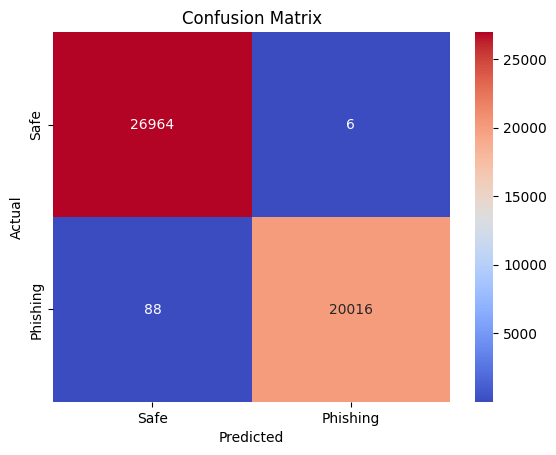

In [25]:
#Heatmap for the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, prediction1)
sns.heatmap(cm,annot=True,fmt='d',cmap='coolwarm',xticklabels=['Safe','Phishing'],yticklabels=['Safe','Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

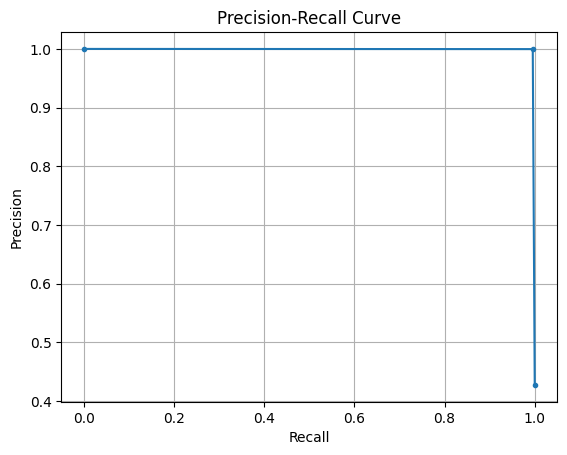

In [26]:
#Precision Recall Store
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, prediction1)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

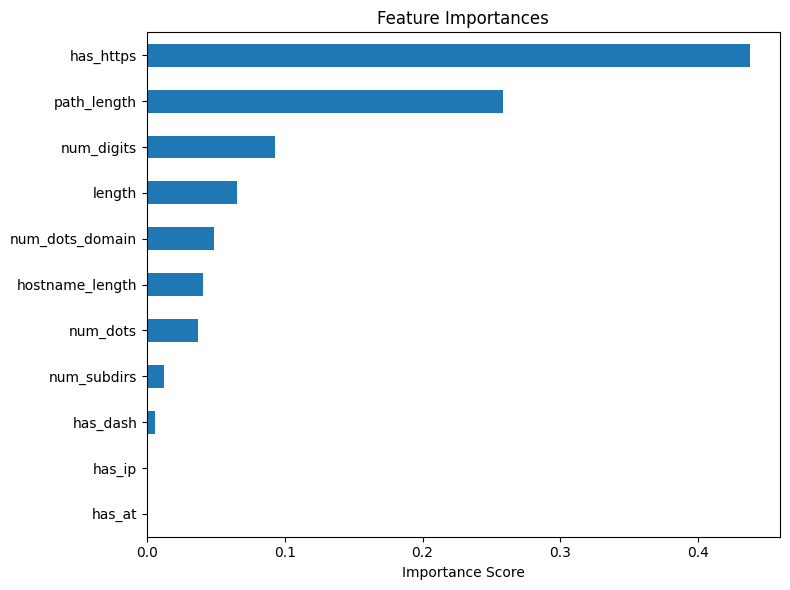

In [27]:
#Feature Importance

feature_importances = pd.Series(model1.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


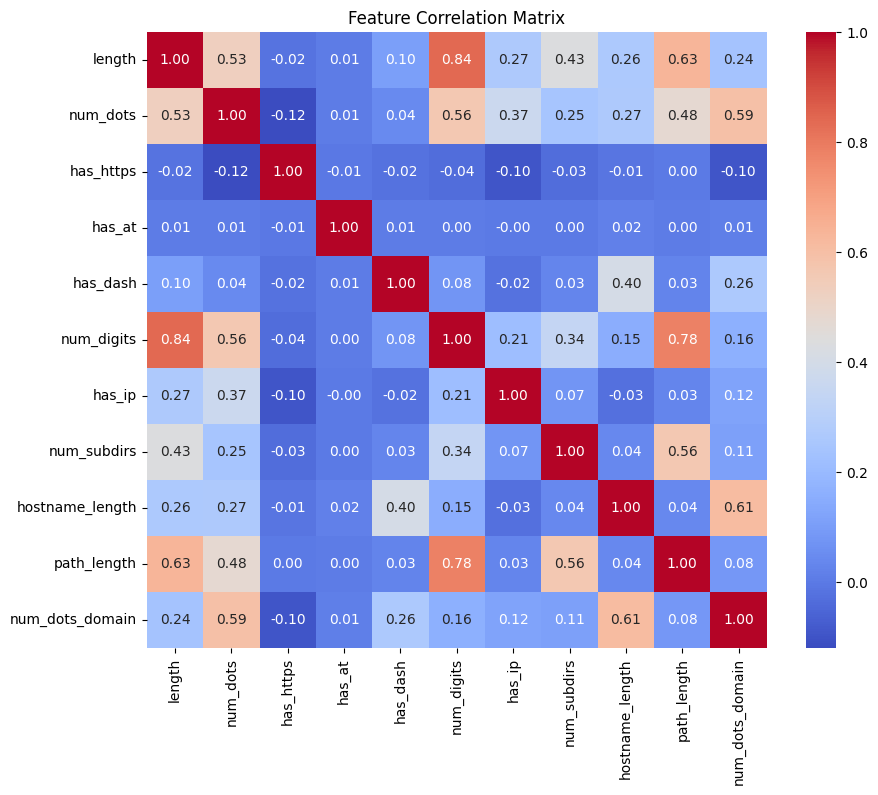

In [28]:
#Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


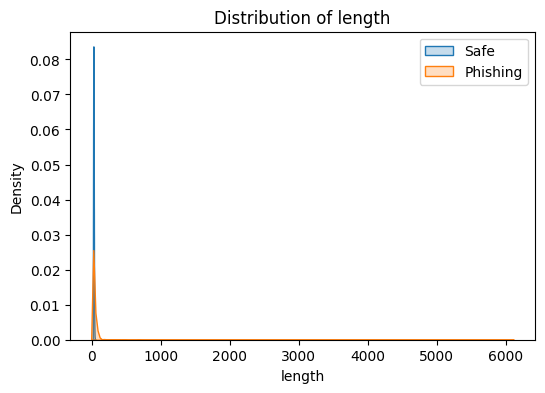

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


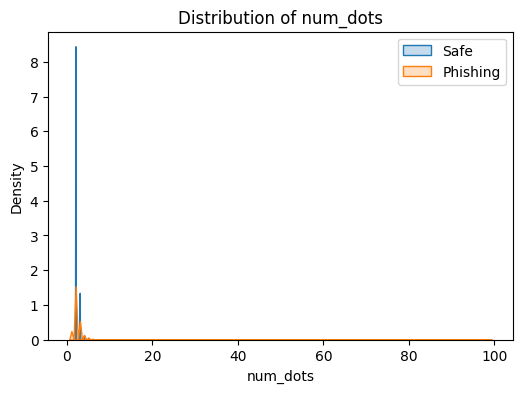

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


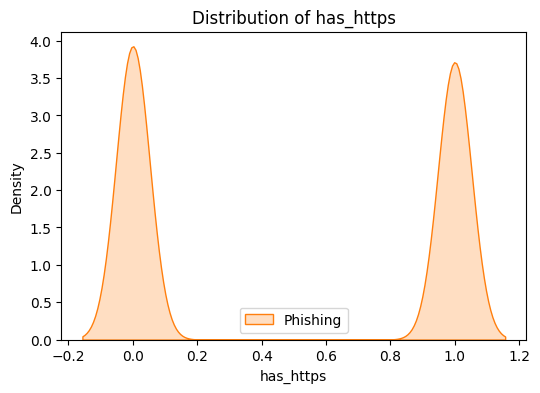

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


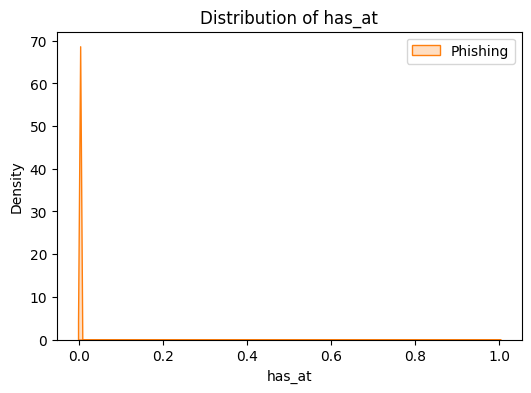

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


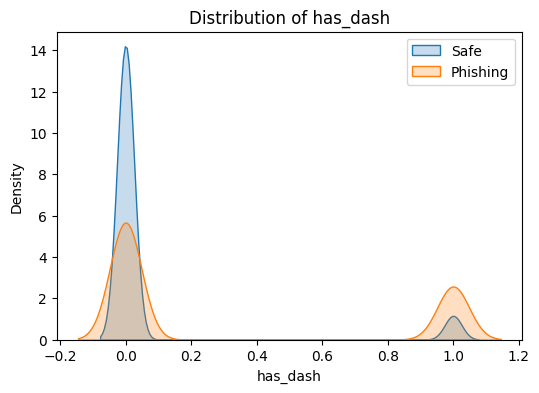

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


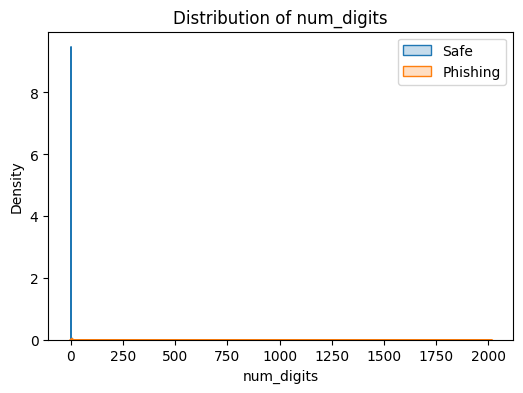

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


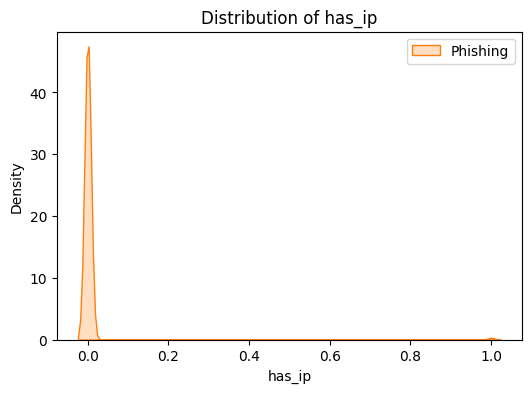

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


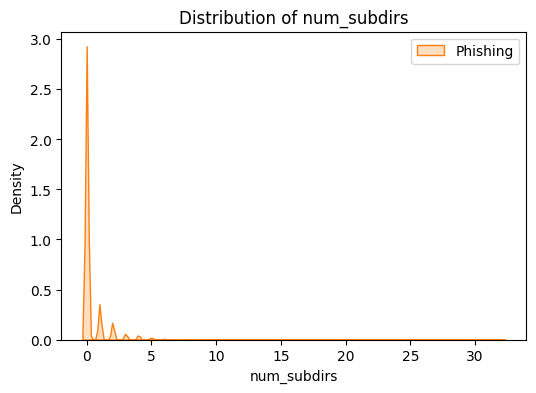

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


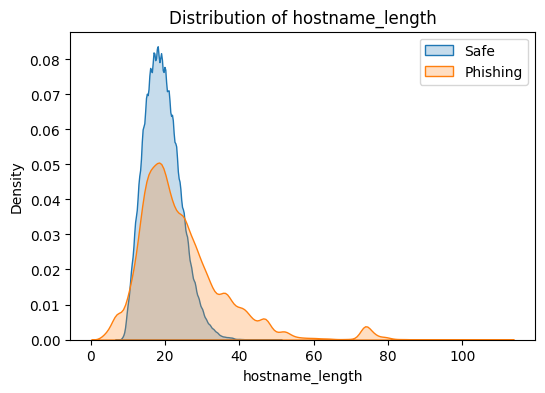

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


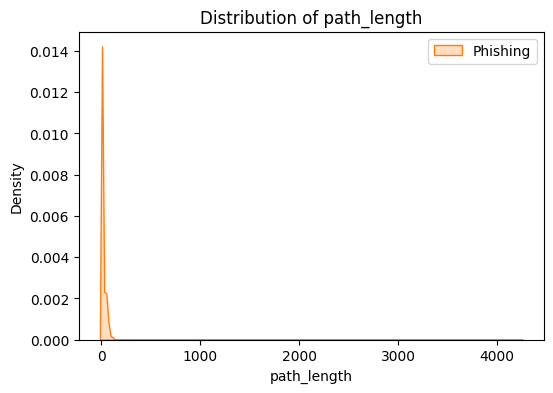

/tmp/ipython-input-60-924580072.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
/tmp/ipython-input-60-924580072.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)


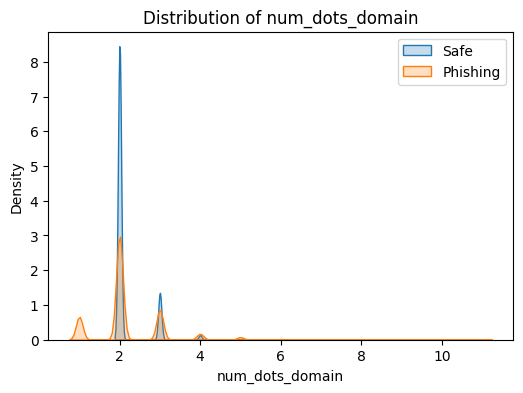

In [ ]:
#Distribution of Features
import matplotlib.pyplot as plt
import seaborn as sns

for feature in X_train.columns:
    plt.figure(figsize=(6,4))
    sns.kdeplot(X_train[feature][y_train==0], label='Safe', shade=True)
    sns.kdeplot(X_train[feature][y_train==1], label='Phishing', shade=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()


In [75]:
import joblib
joblib.dump(model1, 'phishing_model.pkl')


['phishing_model.pkl']